# Gesture Recognition
In this group project, we are going to build two models: 
1. 2D CNN + RNN (using transfer learning and GRU)
2. 3D CNN
Both models will predict the 5 gestures correctly. Importing the following libraries to get started.

In [1]:
import numpy as np
import random as rn
import os
import cv2
import datetime
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Dropout, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")

Set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32  # Experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(30)]  # Using all 30 frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # Calculate the number of full batches
        remainder = len(t) % batch_size  # Calculate the remaining image folders < batch_size
        
        for batch in range(num_batches):  # Iteration over the number of full batches
            batch_data = np.zeros((batch_size, 30, 128, 128, 3))  # (batch_size, num_frames, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoded labels
            for folder in range(batch_size):  # Iteration over the batch_size
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # Read all images in the folder
                for idx, item in enumerate(img_idx):  # Iteration over the frames/images of a folder
                    image = cv2.imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item])
                    image = cv2.resize(image, (128, 128))  # Resizing to 128x128
                    image = image / 255.0  # Normalizing
                    batch_data[folder, idx, :, :, :] = image  # Feed in the image
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1  # One-hot encoding
            yield batch_data, batch_labels  # Yield the batch_data and batch_labels
        
        # Handle the remaining image folders
        if remainder > 0:
            batch_data = np.zeros((remainder, 30, 128, 128, 3))  # (remainder, num_frames, height, width, channels)
            batch_labels = np.zeros((remainder, 5))  # One-hot encoded labels
            for folder in range(remainder):  # Iteration over the remaining image folders
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])  # Read all images in the folder
                for idx, item in enumerate(img_idx):  # Iteration over the frames/images of a folder
                    image = cv2.imread(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item])
                    image = cv2.resize(image, (128, 128))  # Resizing to 128x128
                    image = image / 255.0  # Normalizing
                    batch_data[folder, idx, :, :, :] = image  # Feed in the image
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1  # One-hot encoding
            yield batch_data, batch_labels  # Yield the remaining batch_data and batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels).

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25  # Choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model Development
Here we make the model using different functionalities that Keras provides. We design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1: 2D CNN + RNN (using transfer learning and GRU with Dropout)

Here, we'll be adapting MobileNet as our base model for transfer learning due to it's lightweight architecture and high speed performance as compared to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc.

In [6]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freezing the base model

cnn_model = Sequential()
cnn_model.add(TimeDistributed(base_model, input_shape=(30, 128, 128, 3)))
cnn_model.add(TimeDistributed(Flatten()))

model_2d_rnn = Sequential()
model_2d_rnn.add(cnn_model)
model_2d_rnn.add(GRU(64, return_sequences=False))  # Using GRU instead of LSTM
model_2d_rnn.add(Dropout(0.2)) # Adding Dropout to reduce overfitting
model_2d_rnn.add(Dense(64, activation='relu'))
model_2d_rnn.add(Dense(5, activation='softmax'))  # 5 classes for 5 gestures each

Now that we have written the model, the next step is to compile the model. When we print the summary of the model, we'll see the total number of parameters to be trained.

In [7]:
# Compile the 2D CNN + RNN model
optimiser = optimizers.Adam(learning_rate=0.001)
model_2d_rnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print("2D CNN + RNN Model Summary:")
print(model_2d_rnn.summary())

2D CNN + RNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 30, 16384)           │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │       3,158,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,391,749 (24.38 MB)

 Trainable params: 3,162,885 (12.07 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


### Model 2: 3D CNN (with Dropout)

In [8]:
model_3d_cnn = Sequential()
model_3d_cnn.add(Conv3D(32, (3, 3, 3), input_shape=(30, 128, 128, 3), activation='relu', padding='same'))
model_3d_cnn.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Downsampling by a factor of 2
model_3d_cnn.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model_3d_cnn.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Downsampling by a factor of 2
model_3d_cnn.add(Dropout(0.2))  # Adding Dropout to reduce overfitting
model_3d_cnn.add(Flatten())
model_3d_cnn.add(Dense(128, activation='relu'))
model_3d_cnn.add(Dense(5, activation='softmax'))  # 5 classes for 5 gestures each

Now that we have written the model, the next step is to compile the model. When we print the summary of the model, we'll see the total number of parameters to be trained.

In [9]:
# Compile the 3D CNN model
optimiser = optimizers.Adam(learning_rate=0.001)
model_3d_cnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print("3D CNN Model Summary:")
print(model_3d_cnn.summary())

3D CNN Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32, 32, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 458752)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      58,720,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,779,013 (224.22 MB)

 Trainable params: 58,779,013 (224.22 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the train_generator and the val_generator which will be used in .fit.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
# Model checkpoint and learning rate reduction
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'
if not os.path.exists(model_name):
    os.mkdir(model_name)
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='max', 
                             save_freq='epoch')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by fit to decide the number of `next()` calls it need to make.

In [12]:
# Calculating steps_per_epoch and validation_steps
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [13]:
# Fitting the 2D CNN + RNN model
start_time = time.time()
print("Training 2D CNN + RNN Model...")
history = model_2d_rnn.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                 callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time for 2D CNN + RNN Model: {elapsed_time} seconds")

Training 2D CNN + RNN Model...
Source path =  Project_data/train ; batch size = 32
Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3549 - loss: 1.6302Source path =  Project_data/val ; batch size = 32

Epoch 1: val_categorical_accuracy improved from -inf to 0.68000, saving model to model_init_2025-03-1119_42_58.273950/model-00001-1.44558-0.42232-1.14361-0.68000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - categorical_accuracy: 0.3580 - loss: 1.6218 - val_categorical_accuracy: 0.6800 - val_loss: 1.1436 - learning_rate: 0.0010
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6859 - loss: 1.0614
Epoch 2: val_categorical_accuracy improved from 0.68000 to 0.73000, saving model to model_init_2025-03-1119_42_58.273950/model-00002-0.99616-0.71493-0.86210-0.73000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.6872 - loss: 1.0585 - val_categorical_accuracy: 0.7300 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7756 - loss: 0.8058
Epoch 3: val_categorical_accuracy improved from 0.73000 to 0.83000, saving model to model_init_2025-03-1119_42_58.273950/model-00003-0.69919-0.82202-0.55579-0.83000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.7777 - loss: 0.8009 - val_categorical_accuracy: 0.8300 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8855 - loss: 0.5049
Epoch 4: val_categorical_accuracy did not improve from 0.83000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.8858 - loss: 0.5027 - val_categorical_accuracy: 0.7900 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9168 - loss: 0.3330
Epoch 5: val_categorical_accuracy did not improve from 0.83000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.9169 - loss: 0.3327 - val_categorical_accuracy: 0.8100 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9362 - loss: 0.2854
Epoch 6: val_categorical_accuracy improved from 0.83000 to 0.87000, saving model to model_init_2025-

21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.9363 - loss: 0.2841 - val_categorical_accuracy: 0.8700 - val_loss: 0.4204 - learning_rate: 0.0010
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9621 - loss: 0.1805
Epoch 7: val_categorical_accuracy did not improve from 0.87000
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.9624 - loss: 0.1799 - val_categorical_accuracy: 0.8400 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9655 - loss: 0.1583
Epoch 8: val_categorical_accuracy improved from 0.87000 to 0.93000, saving model to model_init_2025-03-1119_42_58.273950/model-00008-0.13757-0.97285-0.37741-0.93000.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - categorical_accuracy: 0.9658 - loss: 0.1573 - val_categorical_accuracy: 0.9300 - val_loss: 0.3774 - learning_rate: 0.0010
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9876 - loss: 0.1040
Epoch 9: val_categorical_accuracy did not improve from 0.93000
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.9874 - loss: 0.1038 - val_categorical_accuracy: 0.8900 - val_loss: 0.3746 - learning_rate: 0.0010
Epoch 10/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9866 - loss: 0.0710
Epoch 10: val_categorical_accuracy did not improve from 0.93000
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - categorical_accuracy: 0.9865 - loss: 0.0714 - val_categorical_accuracy: 0.9000 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9930 - loss: 0.0722
Epoch 11: val_categorical_accuracy did not improve from 0.93000
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s

21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.9977 - loss: 0.0221 - val_categorical_accuracy: 0.9400 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 19/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9955 - loss: 0.0220
Epoch 19: val_categorical_accuracy did not improve from 0.94000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.9956 - loss: 0.0219 - val_categorical_accuracy: 0.9300 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 20/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9982 - loss: 0.0144
Epoch 20: val_categorical_accuracy did not improve from 0.94000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.9981 - loss: 0.0147 - val_categorical_accuracy: 0.9100 - val_loss: 0.2560 - learning_rate: 0.0010
Epoch 21/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9957 - loss: 0.0139
Epoch 21: val_categorical_accuracy did not improve from 0.94000
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.9972 - loss: 0.0138 - val_categorical_accuracy: 0.9500 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 24/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 1.0000 - loss: 0.0145
Epoch 24: val_categorical_accuracy did not improve from 0.95000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 1.0000 - loss: 0.0144 - val_categorical_accuracy: 0.8700 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 25/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 1.0000 - loss: 0.0116
Epoch 25: val_categorical_accuracy did not improve from 0.95000
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 1.0000 - loss: 0.0116 - val_categorical_accuracy: 0.9100 - val_loss: 0.3065 - learning_rate: 1.0000e-04
Training time for 2D CNN + RNN Model: 1767.002620458603 seconds


In [14]:
#Recording Accuracy and Loss for Model 1: 2D CNN + RNN
acc1 = history.history['categorical_accuracy']
val_acc1 = history.history['val_categorical_accuracy']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

In [15]:
# Fitting the 3D CNN model
start_time = time.time()
print("Training 3D CNN Model...")
history = model_3d_cnn.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                 callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time for 3D CNN Model: {elapsed_time} seconds")

Training 3D CNN Model...
Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2414 - loss: 13.4631
Epoch 1: val_categorical_accuracy did not improve from 0.95000
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.2434 - loss: 13.1603 - val_categorical_accuracy: 0.3700 - val_loss: 1.3580 - learning_rate: 0.0010
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5014 - loss: 1.1448
Epoch 2: val_categorical_accuracy did not improve from 0.95000
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - categorical_accuracy: 0.5057 - loss: 1.1374 - val_categorical_accuracy: 0.6500 - val_loss: 1.0523 - learning_rate: 0.0010
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7704 - loss: 0.5868
Epoch 3: val_categorical_accuracy did not improve from 0.95000
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - categorical_accuracy: 0.7713 - loss: 0.5860 - val_categorical_accuracy: 0.7200 - val_loss: 0.7930 - learning_rate: 0.0010
Epoch 4/25

In [16]:
#Recording Accuracy and Loss for Model 2: 3D CNN
acc2 = history.history['categorical_accuracy']
val_acc2 = history.history['val_categorical_accuracy']

loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

## Model Performance Validation

In [17]:
def plot_accuracy_loss(acc, val_acc, loss, val_loss):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Accuracy & Loss plots for 2D CNN + RNN Model 

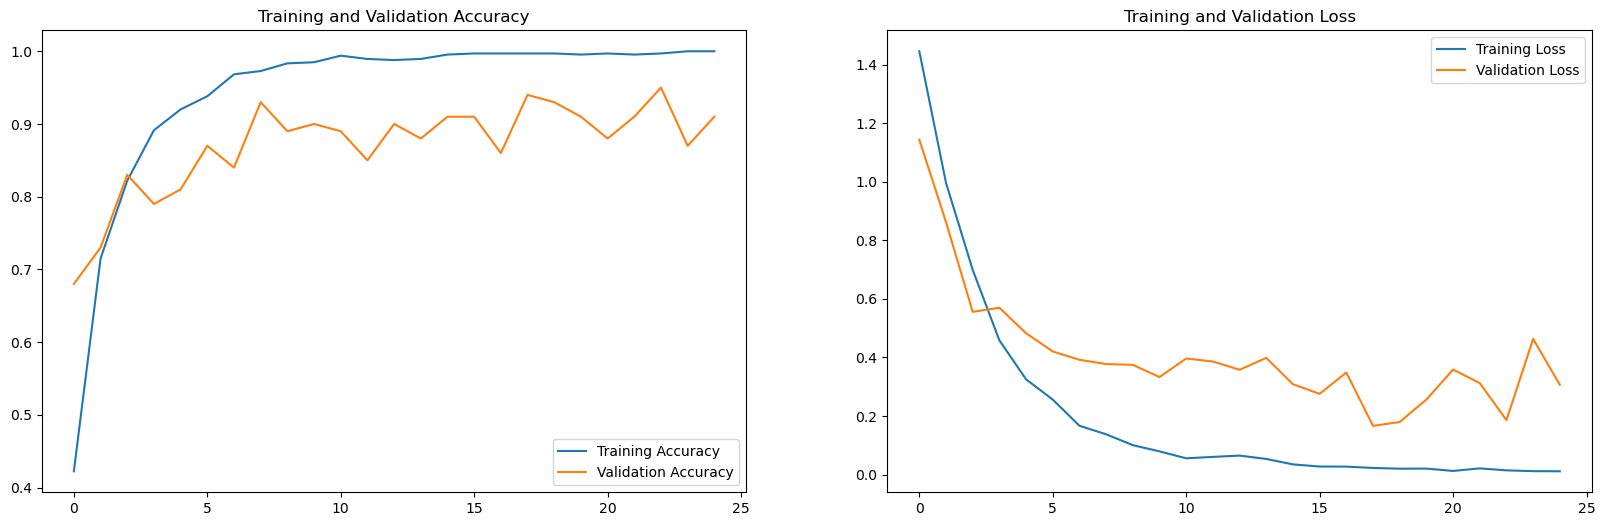

In [18]:
plot_accuracy_loss(acc1, val_acc1, loss1, val_loss1)

### Accuracy & Loss plots for 3D CNN Model 

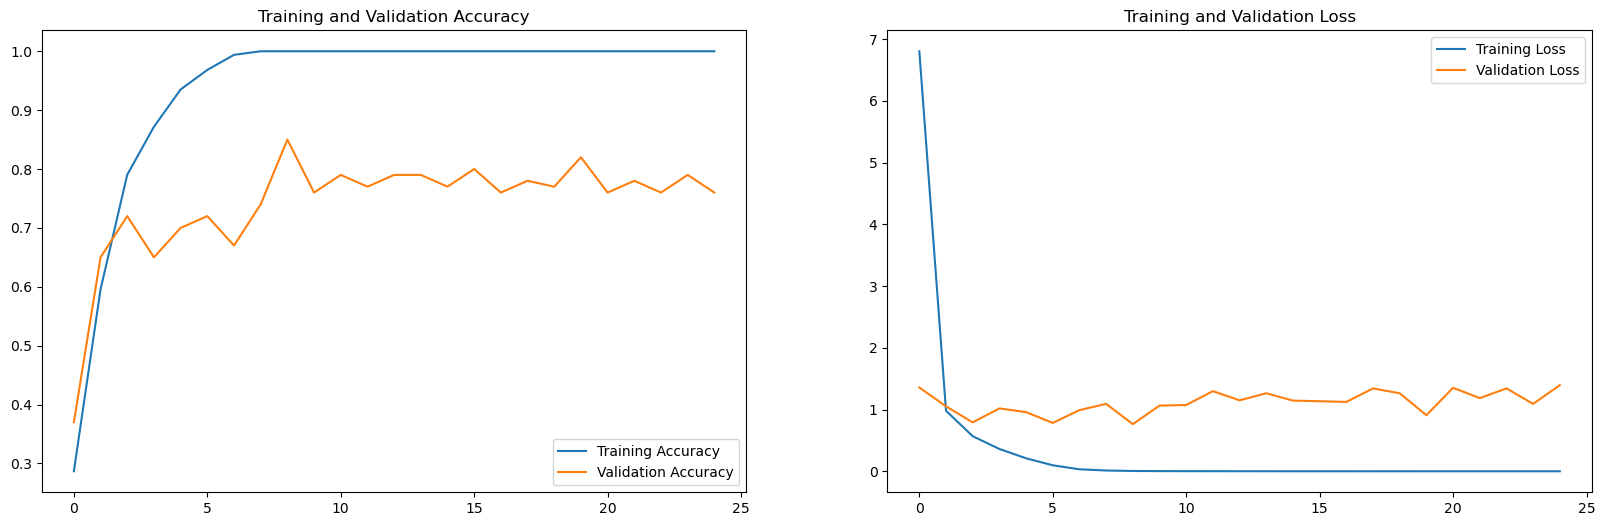

In [19]:
plot_accuracy_loss(acc2, val_acc2, loss2, val_loss2)

## Experimentation on Model Design Hyperparameters

- Out of the standard image dimensions of 128x128, 160x160, 192x192, 224x224, we have chosen **128x128** as the desired image input dimension as it was able to capture the key information from 360x360 sized images and able to capture maximum information from 120x160 images. The model performance validations have also resulted the same.
- We have tested for various epochs and found **25 epochs** to be the optimum model training period for the given data and model designs.
- We tested various batch sizes and used batch size of **32** as it is a standard value and good enough for model training speed and execution.
- Our initial models were developed without dropout which resulted in attaining 100% training accuracy in early stages and validation accuracy being lesser than expected performance resulting in huge overfitting.
- We have experimented with dropout values of 0.2, 0.3, 0.5 and selected **0.2** being the best dropout as it reduced the overfitting significantly and gave maximum validation accuracy for both models.
- To reduce the impact of overfitting observed in 3D CNN model, we have even introduced Batch Normalization but it was unable to attain atleast 50% validation accuracy making the model underperform on new data.
- We have limited to **2 CNN layers** with **32** and **64** filters as best simple architecture for 3D CNN model as the model was unable to perform well on more than 3 layers with high count filters.
- Experimentation was done on various dense layers with high count filters which was simply increasing the trainable parameters but unable to perform better.


## Observations

#### For Model 1: 2D CNN + RNN (using Transfer Learning and GRU with Dropout)

- There are 31,62,885 trainable parameters for the GRU and Dense layers implemented with 32,28,864 non-trainable parameters as part of MobileNet model transfer learning.
- The model has ultimately reached 100% training accuracy in the final stage of training.
- The model has reached its highest validation accuracy of **0.9500** with a validation loss of **0.1858** during 23rd epoch.
- The model had its least validation loss at **0.1662** with a validation accuracy of **0.9400** during 18th epoch.
- From the accuracy and loss plots of the model, it is evident that the validation curves are quite close to the training curves indicating that the model is not overfitting and performs well on new unseen data as well.

#### For Model 2: 3D CNN (with Dropout)

- There are 5,87,79,013 trainable parameters for the complete model and 0 non-trainable parameters as no transfer learning was used.
- The model has reached 100% training accuracy during initial stages of model training.
- The model has reached its highest validation accuracy of **0.8500** with a validation loss of **0.7641** being the least as well during 9th epoch.
- We can observe from the accuracy and loss plots of the model that the validation curves are quite away from the training curves indicating that the model is quite overfitting and might not perform well on new unseen data.

## Conclusion

The model training and performance for the gesture recognition of video frames data has been experimented over various kinds of 2D CNN + RNN and 3D CNN models along with varying design hyperparameters. Ultimately, the 2D CNN + RNN Model designed from MobileNet base model and GRU implementation with dropout is the best model recommended due to its exceptional performance on unseen data with high validation accuracy and low validation loss obtained on the processed image dataset. Whereas the 3D CNN model with dropout was unable to perform well on validation data along with huge number of model parameters leading to another drawback. Considering validation accuracy and loss as primary and secondary constraints respectively, we suggest the model with  highest validation accuracy of 95% and low validation loss of 18.6% as the best performance model to capture and recognize the hand gestures of Smart TV users for content streaming controls.